# IMPORT LIBRARIES

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# IMPORTING DATASET

In [ ]:
dataset_path = "/content/drive/MyDrive/DRDO Internship/Dataset_1000_samples.csv"
df = pd.read_csv(dataset_path)

# Assuming CSV file has columns named "NLP Statement" and "Logic Expression"
english_statements = df["NL Statement"].tolist()
logical_expressions = df["Logic Expression"].tolist()

# TRAIN-TEST SPLIT

In [ ]:
train_inputs, val_inputs, train_outputs, val_outputs = train_test_split(
    english_statements, logical_expressions, test_size=0.1, random_state=42
)

# TOKENIZE DATA

In [ ]:
#Tokenize your training and validation data
#custom_cache_dir = "/content/drive/MyDrive/models--t5-3b"
tokenizer = T5Tokenizer.from_pretrained("t5-base")
#tokenizer = T5Tokenizer.from_pretrained(custom_cache_dir)

train_encodings = tokenizer(train_inputs, return_tensors="pt", padding=True)
train_labels = tokenizer(train_outputs, return_tensors="pt", padding=True)

val_encodings = tokenizer(val_inputs, return_tensors="pt", padding=True)
val_labels = tokenizer(val_outputs, return_tensors="pt", padding=True)

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, train_labels.input_ids)
val_dataset = TensorDataset(val_encodings.input_ids, val_encodings.attention_mask, val_labels.input_ids)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have

# MODEL

In [ ]:
from transformers import T5ForConditionalGeneration

# Define and initialize the T5 model for conditional generation
model = T5ForConditionalGeneration.from_pretrained("t5-base")
#custom_cache_dir = "/content/drive/MyDrive/models--t5-3b/snapshots/bed96aab9ee46012a5046386105ee5fd0ac572f0/"
#model = T5ForConditionalGeneration.from_pretrained(custom_cache_dir)

#Define training parameters
batch_size = 8
epochs = 5

optimizer = optim.AdamW(model.parameters(), lr=0.0005)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# FINE-TUNE

Epoch 1/5, Avg Loss: 0.6698410054751202
Epoch 2/5, Avg Loss: 0.19754955086824114
Epoch 3/5, Avg Loss: 0.12502327459180249
Epoch 4/5, Avg Loss: 0.09009539581571532
Epoch 5/5, Avg Loss: 0.06519026912551011


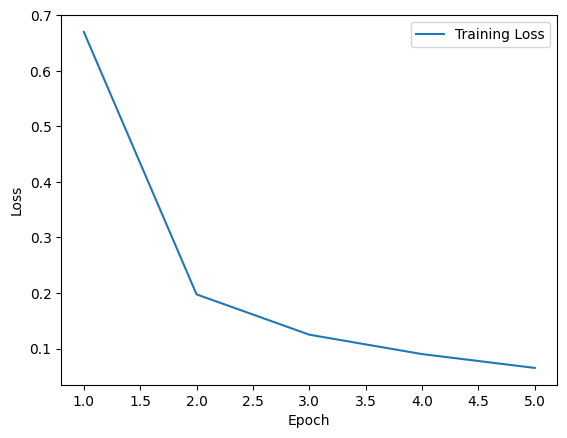

In [ ]:
#Fine-tune the model
model.to(device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_losses = []


for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Avg Loss: {avg_loss}")
    train_losses.append(avg_loss)

plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# EVALUATION

In [ ]:
#Evaluate on the validation set
model.eval()
val_loader = DataLoader(val_dataset)

with torch.no_grad():
    total_val_loss = 0.0
    for batch in val_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        val_loss = outputs.loss
        total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}")

Validation Loss: 0.3175434090544603


# SAVE

In [ ]:
#Save the fine-tuned model
model.save_pretrained("/content/drive/MyDrive/fine_tuned_t5_logical_expression_generator_for_1000examples")
tokenizer.save_pretrained("/content/drive/MyDrive/fine_tuned_t5_logical_expression_generator_for_1000examples")

('/content/drive/MyDrive/fine_tuned_t5_logical_expression_generator_for_1000examples/tokenizer_config.json',
 '/content/drive/MyDrive/fine_tuned_t5_logical_expression_generator_for_1000examples/special_tokens_map.json',
 '/content/drive/MyDrive/fine_tuned_t5_logical_expression_generator_for_1000examples/spiece.model',
 '/content/drive/MyDrive/fine_tuned_t5_logical_expression_generator_for_1000examples/added_tokens.json')

# PREDICTION

In [ ]:
print([val_inputs])

[["The missile launch system's display will show a warning message iff the launch sequence is initiated and a critical failure is detected.", 'Unless there is smoke detected in the vicinity and the fire alarm is triggered, the sprinkler system shall remain inactive. ', 'Unless the weather conditions allow for safe flight and the wind speed is within the specified range, the drone shall not take off unless manually overridden by the user.\xa0 ', 'If a fire is detected in the reactor building and the fire suppression system fails to activate, the nuclear plant shall be shut down as a safety measure.', 'The elevator\'s interior lights will turn off if the cabin is empty and the light control switch is in the "off" position.', 'The power plant will switch to backup sensors if both the primary sensors and the redundant sensors fail to provide accurate readings.', 'If the panic button is pressed or the intrusion alarm is activated, the security cameras shall start recording immediately.', 'T

In [ ]:
# Iterate over each English statement
for statement in val_inputs:
    # Example input
    prompt = statement
    # Tokenize the input
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    # Generate predictions
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    with torch.no_grad():
        input_ids = input_ids.to(device)
        output = model.generate(input_ids, max_length=50)
    # Decode and print the output
    decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
    print(f"English Statement: {statement}")
    print(f"Generated Logic Expression: {decoded_output}\n")


English Statement: The missile launch system's display will show a warning message iff the launch sequence is initiated and a critical failure is detected.
Generated Logic Expression: (Launch Sequence Initiated and Critical Failure Detected) --> (Display Warning Message)

English Statement: Unless there is smoke detected in the vicinity and the fire alarm is triggered, the sprinkler system shall remain inactive. 
Generated Logic Expression: (not(Smoke detected in vicinity and Fire alarm triggered)-->(Sprinkler system inactive)

English Statement: Unless the weather conditions allow for safe flight and the wind speed is within the specified range, the drone shall not take off unless manually overridden by the user.  
Generated Logic Expression: (not(Weather conditions allow for safe flight and Wind speed within specified range)-->(Drone does not take off)

English Statement: If a fire is detected in the reactor building and the fire suppression system fails to activate, the nuclear plan

In [ ]:
# Example input
prompt = "Generate propositional logic for: During landing, the Flight Computer shall apply intermittent wheel brakes only when AIA is false and speed is less than 100 m/s and higher than 80 m/s."
# Tokenize the input
input_ids = tokenizer.encode(prompt, return_tensors="pt")
# Generate predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
  input_ids = input_ids.to(device)
  output = model.generate(input_ids, max_new_tokens=50)
# Decode and print the output
decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
print(decoded_output)

During landing --> (Intermittent wheel brakes applied --> AIA is false and speed  100 m/s and > 80 m/s)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Load the dataset
dataset_path = "dataset.csv"
df = pd.read_csv(dataset_path)

# Split the dataset into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Extract English statements and logic expressions
train_inputs = train_df["NL Statement"].tolist()
train_outputs = train_df["Logic Expression"].tolist()
val_inputs = val_df["NL Statement"].tolist()
val_outputs = val_df["Logic Expression"].tolist()

# Tokenize inputs and outputs
tokenizer = T5Tokenizer.from_pretrained("t5-base")

train_encodings = tokenizer(train_inputs, return_tensors="pt", padding=True, truncation=True)
train_labels = tokenizer(train_outputs, return_tensors="pt", padding=True, truncation=True)
val_encodings = tokenizer(val_inputs, return_tensors="pt", padding=True, truncation=True)
val_labels = tokenizer(val_outputs, return_tensors="pt", padding=True, truncation=True)

# Create TensorDatasets for train and validation sets
train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, train_labels.input_ids)
val_dataset = TensorDataset(val_encodings.input_ids, val_encodings.attention_mask, val_labels.input_ids)

# Define model and training parameters
model = T5ForConditionalGeneration.from_pretrained("t5-base")
batch_size = 8
epochs = 5
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to appropriate device
model.to(device)

# Train the model
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Avg Loss: {avg_loss}")
    train_losses.append(avg_loss)

# Plot training loss
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on the validation set
model.eval()
val_loader = DataLoader(val_dataset)

predicted_logic_expressions = []
true_logic_expressions = []

with torch.no_grad():
    total_val_loss = 0.0
    for batch in val_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        val_loss = outputs.loss
        total_val_loss += val_loss.item()

        # Generate predictions for the current batch
        predicted_ids = model.generate(input_ids, attention_mask=attention_mask, max_length=50)
        for pred_id, label_id in zip(predicted_ids, labels):
            predicted_logic_expressions.append(tokenizer.decode(pred_id, skip_special_tokens=True))
            true_logic_expressions.append(tokenizer.decode(label_id, skip_special_tokens=True))

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_logic_expressions, predicted_logic_expressions)
print("Confusion Matrix:")
print(conf_matrix)
